# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd # подключаем библиотеки

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns

matplotlib.rcParams.update({'font.size': 14}) #просматриваем все столбцы, не исключая середину
pd.options.display.max_columns = 100

In [2]:
try: # загружаем данные в датафрейм
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12678,20,12700000.0,88.9,2018-11-23T00:00:00,3,2.8,5.0,46.0,3,NaN,False,False,27.3,NaN,Санкт-Петербург,24904.0,5472.0,2.0,310.0,0.0,NaN,43.0
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,NaN,10.0,NaN,6,NaN,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7093,1,2600000.0,36.4,2018-08-10T00:00:00,1,NaN,12.0,16.4,6,NaN,False,False,10.0,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,70.0
18050,13,1600000.0,49.9,2019-04-20T00:00:00,2,3.1,2.0,32.7,2,NaN,False,False,7.4,NaN,Подпорожье,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19390,8,3680000.0,43.5,2018-10-04T00:00:00,1,2.6,17.0,16.8,11,NaN,False,False,9.3,NaN,Санкт-Петербург,18750.0,22175.0,0.0,NaN,1.0,649.0,179.0


In [3]:
print('Количество строк данных', data.shape[0])
print('Количество столбцов данных', data.shape[1])

Количество строк данных 23699
Количество столбцов данных 22


Данные представлены в следующем виде:
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м);
- `balcony` — число балконов;
- `ceiling_height` — высота потолков (м);
- `cityCenters_nearest` — расстояние до центра города (м);
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия);
- `first_day_exposition` — дата публикации;
- `floor` — этаж;
- `floors_total` — всего этажей в доме;
- `is_apartment` — апартаменты (булев тип);
- `kitchen_area` — площадь кухни в квадратных метрах (м²);
- `last_price` — цена на момент снятия с публикации;
- `living_area` — жилая площадь в квадратных метрах (м²);
- `locality_name` — название населённого пункта;
- `open_plan` — свободная планировка (булев тип);
- `parks_around3000` — число парков в радиусе 3 км;
- `parks_nearest` — расстояние до ближайшего парка (м);
- `ponds_around3000` — число водоёмов в радиусе 3 км;
- `ponds_nearest` — расстояние до ближайшего водоёма (м);
- `rooms` — число комнат;
- `studio` — квартира-студия (булев тип);
- `total_area` — общая площадь квартиры в квадратных метрах (м²);
- `total_images` — число фотографий квартиры в объявлении.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.describe() # информация для последующих сравнений и исследования выбросов

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

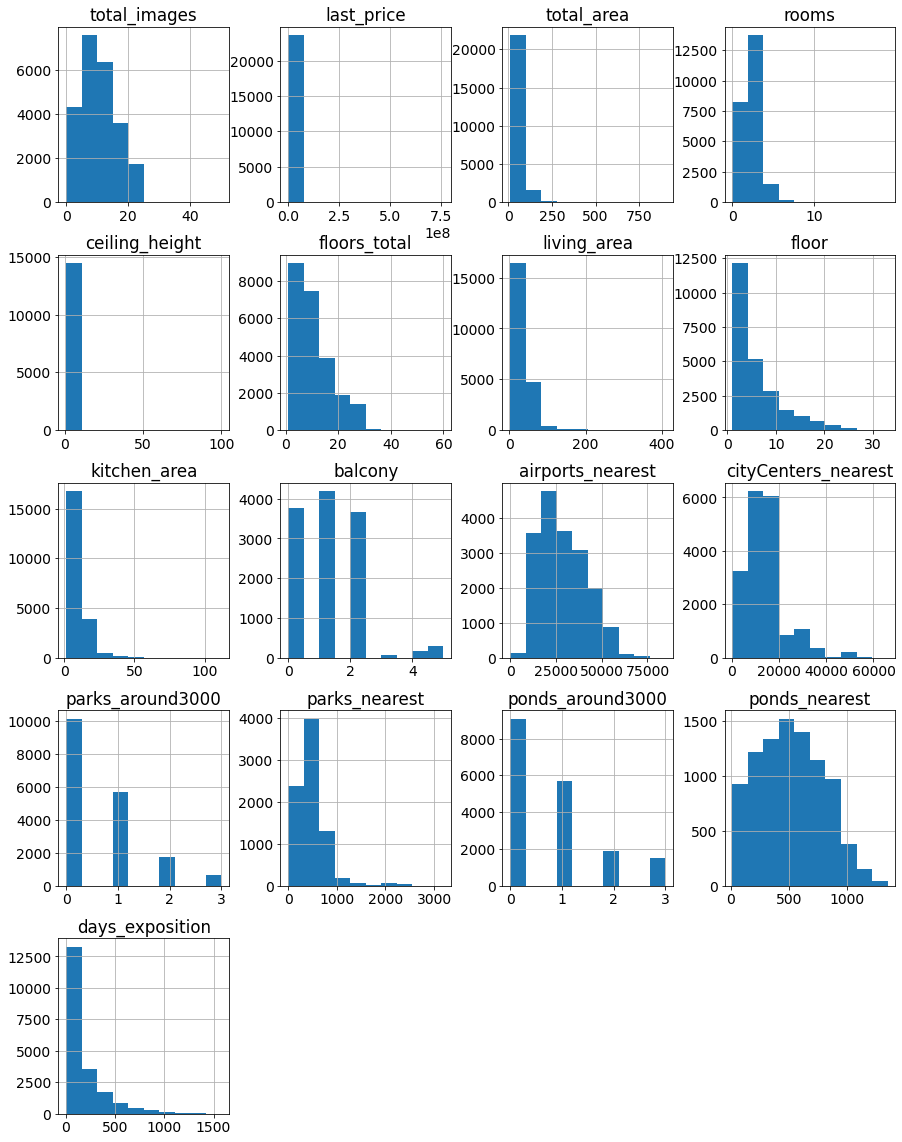

In [6]:
data.hist(figsize=(15, 20))

   Данные в датафрейме разделены символом табуляции, который нужно указать для корректного отображения информации.
   В таблице 22 столбца и 23 699 строк.
   
<b>Данные содержат следующие типы переменных:</b>
   - количественные: total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_nearest, ponds_around3000, days_exposition;
   - категориальные: locality_name;
   - логические: is_apartment, studio, open_plan.
   
<b>В данных выявлены пропуски:</b> в столбцах ceiling_height (14504), floors_total (23613),
    living_area (21796), is_apartment (2775), kitchen_area (21421), balcony (12180),
    locality_name (23650), airports_nearest (18157), cityCenters_nearest (18180), 
    parks_around3000 (18181), parks_nearest (8079), ponds_around3000 (18181), days_exposition(20518).
    
<b>Имеются выбросы данных в столбцах:</b>
    
- `total_images` - число фотографий 0;  
- `rooms` - минимальное число комнат - 0;
- `ceiling_height` - минимальная высота потолка указана 1м, а максимальная - 100м;
- `floors_total` - максимальное число этажей 60 (нуждается в проверке, т.к. может оказывать значительное влияние на статистические показатели);
- `floor` - то же самое в отношении максимального 33 этажа;
- `airports_nearest`, `parks_around3000`, `parks_nearest`, `ponds_nearest` нулевые значения в столбцах - могут быть или сознательно пропущены, или данные объекты могут отсутствовать.

<b>Имеются несоответствия в типах данных столбцов:</b>
- `first_day_exposition` - должен быть тип datetime;
- `floors_total` - должен быть тип int, т.к. число этажей не может быть дробным числом;
- `is_apartment` - должен быть тип bool;
- `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` - тип int.

## Предобработка данных

In [7]:
data.isna().sum() # проверим в каких стобцах есть пропуски, подсчитаем их количество

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
pd.DataFrame(data.isna().sum()).style.background_gradient('Blues') # визуализируем данные

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,9195
floors_total,86
living_area,1903
floor,0
is_apartment,20924


### Обработка пропусков в `locality_name`

In [9]:
data.dropna(subset = ['locality_name'], inplace=True) # удаляем 49 пропусков 

In [10]:
data['locality_name'].isna().sum() # проверяем

0

In [11]:
# удаляем неявные дубликаты, переводя названия в нижний регистр
data['locality_name'] = data['locality_name'].str.lower()
# заменяем букву "ё" на "е"
data['locality_name'] = data['locality_name'].str.replace('ё','е')
#удаляем не имеющие значения слова
data['locality_name'] = data['locality_name'].str.replace('городской','')
data['locality_name'] = data['locality_name'].str.replace('городского типа','')
data['locality_name'] = data['locality_name'].str.replace('поселок', '')
data['locality_name'] = data['locality_name'].str.replace('деревня', '')
data['locality_name'] = data['locality_name'].str.replace('село','')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество','')
data['locality_name'] = data['locality_name'].str.replace('имени','')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество','') 
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной станции','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный','')
data['locality_name'] = data['locality_name'].str.replace('станции','')
data['locality_name'] = data['locality_name'].str.replace('пансионат','')
#удаляем пробелы слева и справа
data['locality_name'] = data['locality_name'].str.rstrip ()
data['locality_name'] = data['locality_name'].str.lstrip ()
print(len(data['locality_name'].unique()))
print(data['locality_name'].unique())

305
['санкт-петербург' 'шушары' 'янино-1' 'парголово' 'мурино' 'ломоносов'
 'сертолово' 'петергоф' 'пушкин' 'кудрово' 'коммунар' 'колпино'
 'красный бор' 'гатчина' 'федоровское' 'выборг' 'кронштадт' 'кировск'
 'новое девяткино' 'металлострой' 'лебяжье' 'сиверский' 'молодцово'
 'кузьмоловский' 'новая ропша' 'павловск' 'пикколово' 'всеволожск'
 'волхов' 'кингисепп' 'приозерск' 'сестрорецк' 'куттузи' 'аннино'
 'ефимовский' 'плодовое' 'заклинье' 'торковичи' 'первомайское' 'красное'
 'понтонный' 'сясьстрой' 'старая' 'лесколово' 'новый свет' 'сланцы'
 'путилово' 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск'
 'сосновый бор' 'оржицы' 'кальтино' 'романовка' 'бугры' 'рощино' 'кириши'
 'луга' 'волосово' 'отрадное' 'павлово' 'оредеж' 'копорье' 'молодежное'
 'тихвин' 'победа' 'нурма' 'синявино' 'тосно' 'стрельна' 'бокситогорск'
 'александровская' 'лопухинка' 'пикалево' 'терволово' 'советский'
 'подпорожье' 'петровское' 'токсово' 'сельцо' 'вырица' 'кипень' 'келози'
 'вартемяги' 'тельмана' 'с

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               12137 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Обработка  пропусков в `ceiling_height` - заполняем данные медианными значениями по локации

In [13]:
print(len(data.loc[(data['ceiling_height'] > 5.0) | (data['ceiling_height'] < 1.6)]))

38


In [14]:
data.info()
print(data.loc[(data['ceiling_height'] > 5.0) | (data['ceiling_height'] < 1.6)].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               12137 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видим небольшое количество выбросов. Так как они могут значительно повлиять на средние значения, очистим данные.

In [15]:
# удаляем некорректные данные
data = data.drop(data.loc[(data['ceiling_height'] > 5.0) | (data['ceiling_height'] < 1.6)].index)

In [16]:
data.info()
print(data.loc[(data['ceiling_height'] > 5.0) | (data['ceiling_height'] < 1.6)].head()) # проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23612 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23612 non-null  int64  
 1   last_price            23612 non-null  float64
 2   total_area            23612 non-null  float64
 3   first_day_exposition  23612 non-null  object 
 4   rooms                 23612 non-null  int64  
 5   ceiling_height        14452 non-null  float64
 6   floors_total          23527 non-null  float64
 7   living_area           21716 non-null  float64
 8   floor                 23612 non-null  int64  
 9   is_apartment          2747 non-null   object 
 10  studio                23612 non-null  bool   
 11  open_plan             23612 non-null  bool   
 12  kitchen_area          21352 non-null  float64
 13  balcony               12112 non-null  float64
 14  locality_name         23612 non-null  object 
 15  airports_nearest   

In [17]:
data['ceiling_height'].isna().sum() # всего пропусков в столбце

9160

In [18]:
total_ceiling_height_median = data['ceiling_height'].median()
# заполняем пропуски медианными значениями - где возможно по населенным пунктам, а там где медиану
# всвязи с недостатком данных высчитать невозможно - медианным значением по всей выборке
for locality_name in data['locality_name'].unique():
    median_ceiling_height = data.loc[data['locality_name']==locality_name, 'ceiling_height'].median()
# median_ceiling_height может не сосчитаться, если в данных имеется только одна строка 
# с данной локализацией, и именно в ней и находится пропуск  
    if median_ceiling_height >= 0: 
        data.loc[(data['ceiling_height'].isna()) & (data['locality_name']==locality_name), 'ceiling_height'] = median_ceiling_height
    else: # присваиваем значение медианы по всему столбцу
        data.loc[(data['ceiling_height'].isna()) & (data['locality_name']==locality_name), 'ceiling_height'] = total_ceiling_height_median

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

In [19]:
print('Количество пропусков', data['ceiling_height'].isna().sum()) # проверяем

Количество пропусков 0


### Обработка `first_day_exposition`

In [20]:
# изменяем формат на datetime и переводим в формат без указания времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
#print(data.head())

### Обработка `days_exposition`

In [21]:
#заменим пропуски в days_exposition на нулевое значение и заменим тип данных на целочисленный
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')
#print(data.head())
#data.info()

### Обработка `is_apartment` - замена типа данных на bool

In [22]:
data['is_apartment'] = data['is_apartment'].astype('bool')
#data.info()   

### Обработка данных `floors_total` - заполнение пропусков и замена типа данных на целочисленный

In [23]:
data['floors_total'].isna().sum()

85

In [24]:
#заполняем пропуски данными из столбца `floor`, где нет пропусков
#скорее всего, данные об общей этажности не были заполнены, т.к. в столбце `floor` уже был указан этаж
data['floors_total'] = data['floors_total'].fillna(data['floor'])
data['floors_total'].isna().sum()

0

In [25]:
# изменяем тип данных на целочисленный
data['floors_total'] = data['floors_total'].astype('int')
#data.info()

In [26]:
# выявляем выбросы в данных об этажности. Для этого выведем список уникальных значений
# населенных пунктов, где обозначены дома выше 15 этажей
sky_scrappers = data.query('floors_total > 15')
print(sky_scrappers['locality_name'].unique())
int = data.loc[data['floors_total'].max(), 'locality_name']
print('Самый высокий небоскреб', data['floors_total'].max(), 'этажей расположен в', int)

['санкт-петербург' 'парголово' 'мурино' 'кудрово' 'шушары' 'всеволожск'
 'новое девяткино' 'колпино' 'бугры' 'сосновый бор' 'тосно'
 'александровская' 'новогорелово' 'металлострой' 'старая' 'никольское'
 'кировск' 'понтонный' 'свердлова' 'кронштадт' 'тельмана' 'петро-славянка'
 'гатчина' 'сестрорецк' 'сертолово' 'янино-1' 'павловск' 'лаврики'
 'шлиссельбург' 'дубровка' 'колтуши' 'рощино']
Самый высокий небоскреб 60 этажей расположен в мурино


In [27]:
#Видимо, данные из небольших населенных пунктов ложные. заменяем их на более достоверные
#данные из столбца `floor`
data.loc[(data['floors_total'] > 15) & (data['floors_total']!='санкт-петербург'), 'floors_total'] = data['floor']

In [28]:
#проверяем данные - список населенных пунктов значительно уменьшился, 
sky_scrappers = data.query('floors_total > 15')
print(sky_scrappers['locality_name'].unique())
int = data.loc[data['floors_total'].max(), 'locality_name']
print('Самый высокий небоскреб', data['floors_total'].max(), 'этажа расположен в', int)

['санкт-петербург' 'мурино' 'парголово' 'шушары' 'всеволожск'
 'новое девяткино' 'кудрово' 'бугры' 'никольское' 'кировск' 'свердлова'
 'сестрорецк' 'металлострой' 'лаврики' 'кронштадт' 'сертолово' 'колпино'
 'дубровка']
Самый высокий небоскреб 33 этажа расположен в колпино


In [29]:
print('Общее число небоскребов за исключением Санкт-петербурга', len(sky_scrappers.loc[sky_scrappers['locality_name'] != 'санкт-петербург'])) 

Общее число небоскребов за исключением Санкт-петербурга 435


Данные все еще далеки от совершенства. Они составляют
около 2%. Поиск в сети выдает, что самый высокий дом в Колпино - 24 этажа.

In [30]:
data.info() #удаляем строки с заведомо недостоверными данными

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23612 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23612 non-null  int64         
 1   last_price            23612 non-null  float64       
 2   total_area            23612 non-null  float64       
 3   first_day_exposition  23612 non-null  datetime64[ns]
 4   rooms                 23612 non-null  int64         
 5   ceiling_height        23612 non-null  float64       
 6   floors_total          23612 non-null  int64         
 7   living_area           21716 non-null  float64       
 8   floor                 23612 non-null  int64         
 9   is_apartment          23612 non-null  bool          
 10  studio                23612 non-null  bool          
 11  open_plan             23612 non-null  bool          
 12  kitchen_area          21352 non-null  float64       
 13  balcony         

In [31]:
print(len(data.loc[(data['locality_name'] != 'санкт-петербург') & (data['floor'] > 15)]))
data = data.drop(data.loc[(data['locality_name'] != 'санкт-петербург') & (data['floor'] > 15), 'floor'].index)


435


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23177 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23177 non-null  int64         
 1   last_price            23177 non-null  float64       
 2   total_area            23177 non-null  float64       
 3   first_day_exposition  23177 non-null  datetime64[ns]
 4   rooms                 23177 non-null  int64         
 5   ceiling_height        23177 non-null  float64       
 6   floors_total          23177 non-null  int64         
 7   living_area           21327 non-null  float64       
 8   floor                 23177 non-null  int64         
 9   is_apartment          23177 non-null  bool          
 10  studio                23177 non-null  bool          
 11  open_plan             23177 non-null  bool          
 12  kitchen_area          20986 non-null  float64       
 13  balcony         

### Обработка `balcony` - замена пропусков на нулевое значение и изменение типа данных

In [33]:
data['balcony'] = data['balcony'].fillna(0).astype('int')
#data.info()

### Обработка `parks_around3000` и `ponds_around3000`. 
Замена пропусков на нулевые значения и изменение типов данных.

In [34]:
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23177 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23177 non-null  int64         
 1   last_price            23177 non-null  float64       
 2   total_area            23177 non-null  float64       
 3   first_day_exposition  23177 non-null  datetime64[ns]
 4   rooms                 23177 non-null  int64         
 5   ceiling_height        23177 non-null  float64       
 6   floors_total          23177 non-null  int64         
 7   living_area           21327 non-null  float64       
 8   floor                 23177 non-null  int64         
 9   is_apartment          23177 non-null  bool          
 10  studio                23177 non-null  bool          
 11  open_plan             23177 non-null  bool          
 12  kitchen_area          20986 non-null  float64       
 13  balcony         

### Обработка `airports_nearest` и `cityCenters_nearest` - присваиваем медианные значения для каждого населенного пункта. 

In [35]:
median_airports_nearest = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc='median')
median_airports_nearest.head()

,airports_nearest
locality_name,
александровская,12896.5
белоостров,57769.0
зеленогорск,72282.0
колпино,26232.0
красное,25717.0


In [36]:
#общая функция для заполнения колонок на основе pivot_table
def columns_fillna(row, pivot_table, aim_column, index_columns):
    if pd.isnull(row[aim_column]):
        index = (index_columns[0])
        if index in pivot_table.index:
            return pivot_table.loc[index][0]
        else:
            return data[aim_column].median()
    else:
        return row[aim_column]

In [37]:
data['airports_nearest'] = data.apply(columns_fillna,
                                      pivot_table = median_airports_nearest,
                                      aim_column = 'airports_nearest',
                                      index_columns = 'locality_name',
                                      axis = 1)

In [38]:
median_cityCenters_nearest = data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='median')
median_cityCenters_nearest.head()

,cityCenters_nearest
locality_name,
александровская,27468.0
белоостров,38868.0
зеленогорск,53381.0
колпино,32018.0
красное,29142.0


In [39]:
data['cityCenters_nearest'] = data.apply(columns_fillna,
                                      pivot_table = median_airports_nearest,
                                      aim_column = 'cityCenters_nearest',
                                      index_columns = 'locality_name',
                                      axis = 1)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23177 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23177 non-null  int64         
 1   last_price            23177 non-null  float64       
 2   total_area            23177 non-null  float64       
 3   first_day_exposition  23177 non-null  datetime64[ns]
 4   rooms                 23177 non-null  int64         
 5   ceiling_height        23177 non-null  float64       
 6   floors_total          23177 non-null  int64         
 7   living_area           21327 non-null  float64       
 8   floor                 23177 non-null  int64         
 9   is_apartment          23177 non-null  bool          
 10  studio                23177 non-null  bool          
 11  open_plan             23177 non-null  bool          
 12  kitchen_area          20986 non-null  float64       
 13  balcony         

### Переводим метры в километры для большей наглядности

Пропуски в данных о расстоянии до ближайших парков и водоемов восстановить корректно невозможно, т.к. заменить их нулевыми знвчениями неправильно, а пропуск был вызван отсутствием этих признаков.

In [41]:
data[['airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']] = data[['airports_nearest', 'cityCenters_nearest','parks_nearest', 'ponds_nearest']].apply(lambda x: x / 1000)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,8,51.0,8,True,False,False,25.0,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,True,False,False,11.0,2,шушары,12.817,18.603,0,NaN,0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,True,False,False,8.3,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,NaN,9,True,False,False,NaN,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121


### Обработка 'living_area' и 'kitchen_area'. 

Подставляем средние значения, т.к. число этих пропусков в выборке невелико.

In [42]:
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [43]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121


### Обработка 'last_price'. Переводим данные в миллионы рублей.

In [44]:
data['last_price'] = data['last_price'].astype('int')
data['last_price'] = data['last_price'].apply(lambda x: x / 1000000)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13.000,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0
1,7,3.350,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558
3,0,64.900,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121


In [45]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15136
ponds_around3000            0
ponds_nearest           14146
days_exposition             0
dtype: int64

## Посчитайте и добавьте в таблицу новые столбцы

### Цена одного квадратного метра

In [46]:
data['price_of_meter2'] = round(data['last_price']/data['total_area'], 1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter2
0,20,13.000,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0,0.1
1,7,3.350,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81,0.1
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558,0.1
3,0,64.900,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424,0.4
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121,0.1


### День публикации объявления,  месяц публикации объявления, год публикации объявления

In [47]:
data['day_exposition'] = data['first_day_exposition'].dt.dayofweek
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter2,day_exposition,month_exposition,year_exposition
0,20,13.000,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0,0.1,3,3,2019
1,7,3.350,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81,0.1,1,12,2018
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558,0.1,3,8,2015
3,0,64.900,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424,0.4,4,7,2015
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121,0.1,1,6,2018


### Тип этажа квартиры

In [48]:
def type_of_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['type_of_floor'] = data.apply(type_of_floor, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter2,day_exposition,month_exposition,year_exposition,type_of_floor
0,20,13.000,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0,0.1,3,3,2019,последний
1,7,3.350,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81,0.1,1,12,2018,первый
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558,0.1,3,8,2015,другой
3,0,64.900,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424,0.4,4,7,2015,другой
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121,0.1,1,6,2018,другой


### Расстояние в км до центра города

In [49]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'], 0)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter2,day_exposition,month_exposition,year_exposition,type_of_floor,cityCenters_nearest_km
0,20,13.000,108.0,2019-03-07,3,2.70,8,51.000000,8,True,False,False,25.00000,0,санкт-петербург,18.863,16.028,1,0.482,2,0.755,0,0.1,3,3,2019,последний,16.0
1,7,3.350,40.4,2018-12-04,1,2.63,11,18.600000,1,True,False,False,11.00000,2,шушары,12.817,18.603,0,NaN,0,NaN,81,0.1,1,12,2018,первый,19.0
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.300000,4,True,False,False,8.30000,0,санкт-петербург,21.741,13.933,1,0.090,2,0.574,558,0.1,3,8,2015,другой,14.0
3,0,64.900,159.0,2015-07-24,3,2.70,14,90.967492,9,True,False,False,27.70143,0,санкт-петербург,28.098,6.800,2,0.084,3,0.234,424,0.4,4,7,2015,другой,7.0
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.000000,13,True,False,False,41.00000,0,санкт-петербург,31.856,8.098,2,0.112,1,0.048,121,0.1,1,6,2018,другой,8.0


## Проведите исследовательский анализ данных

### Общая площадь

In [50]:
data['total_area'].describe()

count    23177.000000
mean        60.549148
std         35.727922
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

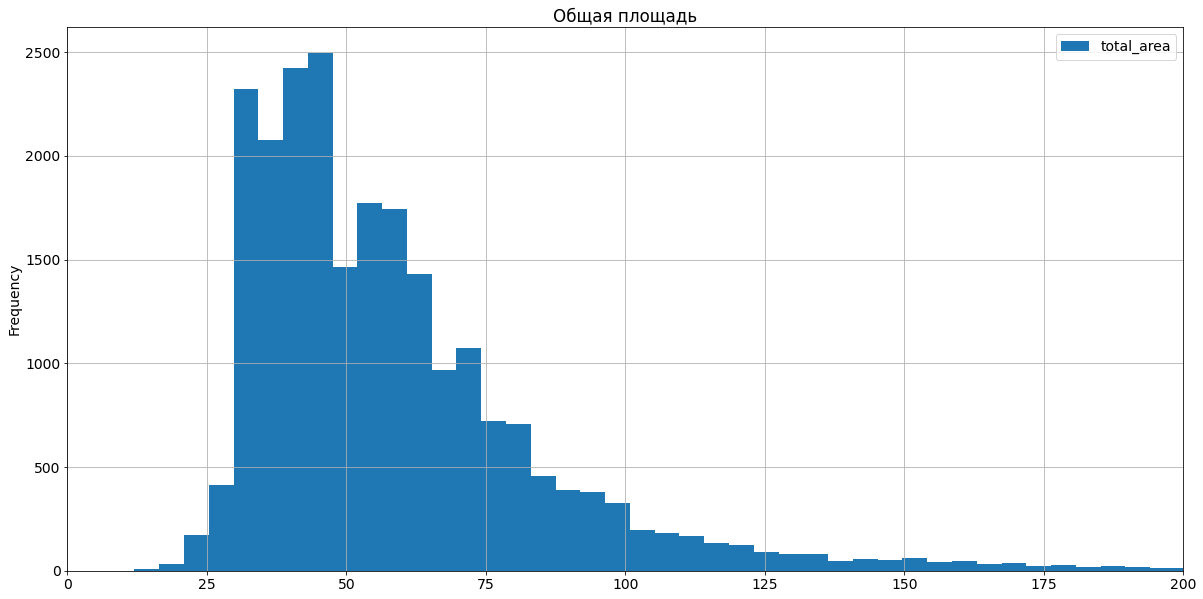

In [51]:
data.plot(kind='hist', title='Общая площадь', y='total_area', bins=200, grid=True, figsize=(20,10))
plt.xlim([0, 200])
plt.show()

Больше всего похоже на распределение Пуассона. Средняя площадь недвижимости около 50кв.м. Пики на отдельных значенияч, видимо вызваны продажей недвижимости типовой застройки.

### Жилая площадь

In [52]:
data['living_area'].describe()

count    23177.000000
mean        34.770056
std         22.381263
min          2.000000
25%         19.000000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

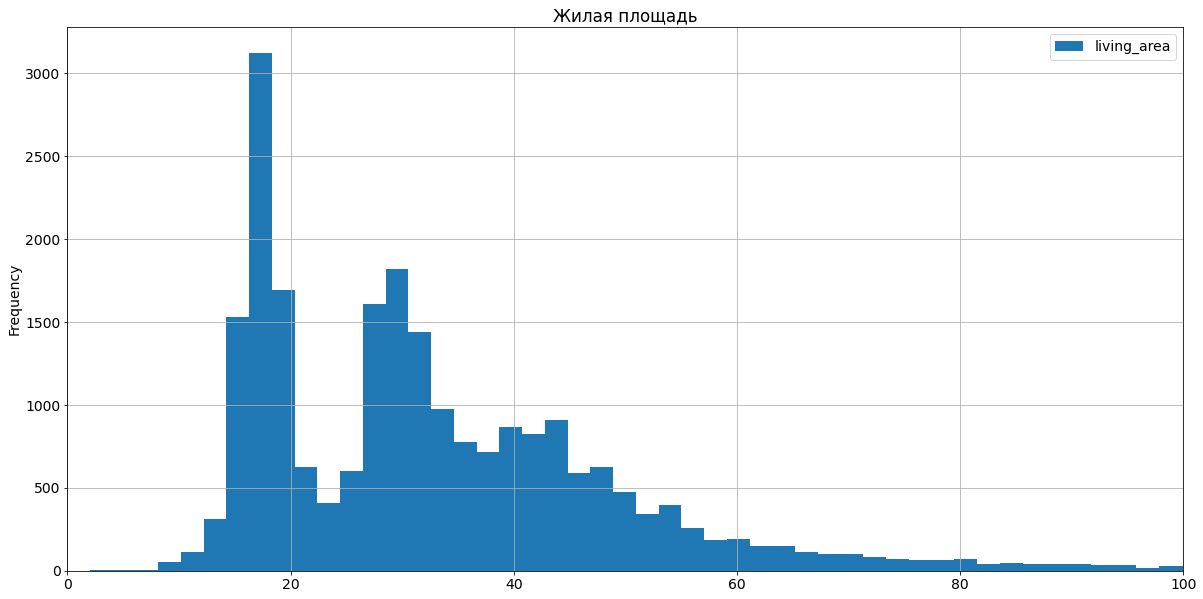

In [53]:
data.plot(kind='hist', title='Жилая площадь', y='living_area', bins=200, grid=True, figsize=(20,10))
plt.xlim([0, 100])
plt.show()

Имеются три пика в районе 19, 30 и 42кв.м. Также может быть связано с метражом типовой застройки.

### Площадь кухни

In [54]:
data['kitchen_area'].describe()

count    23177.000000
mean        10.488773
std          6.045631
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

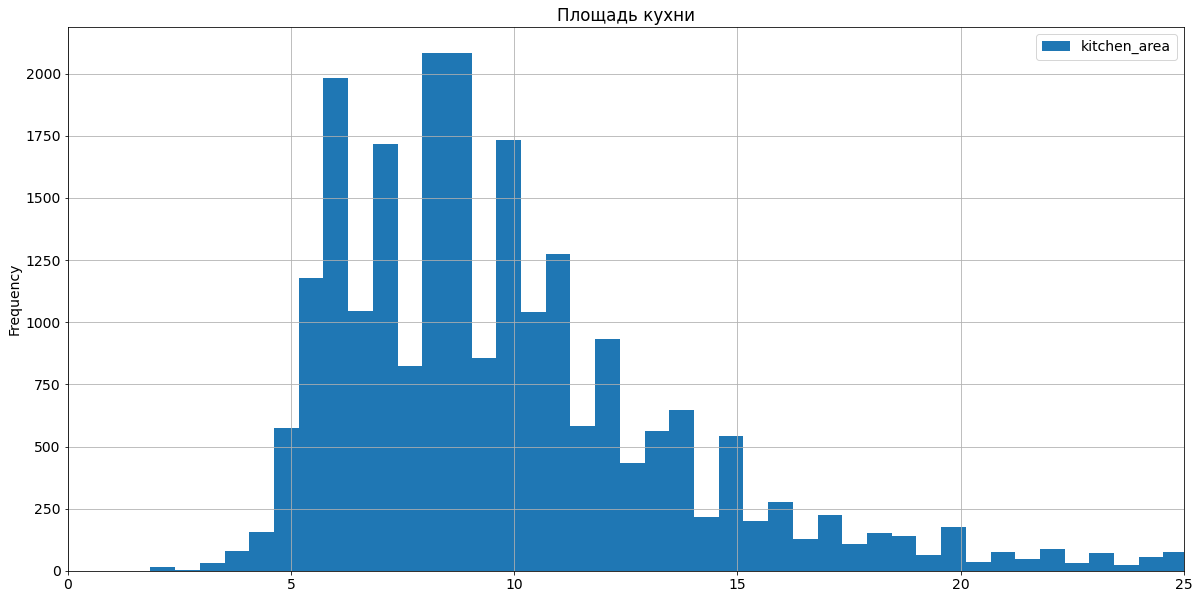

In [55]:
data.plot(kind='hist', title='Площадь кухни', y='kitchen_area', bins=200, grid=True, figsize=(20,10))
plt.xlim([0, 25])
plt.show()

Распределение также напоминает распределение Пуассона. Таже может коррелировать с площадями 
типовой застройки. Большинство кухонь укладываются в 7 - 12кв.м.

### Цена объекта в млн.руб.

In [56]:
data['last_price'].describe()

count    23177.000000
mean         6.571626
std         10.916394
min          0.012190
25%          3.450000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

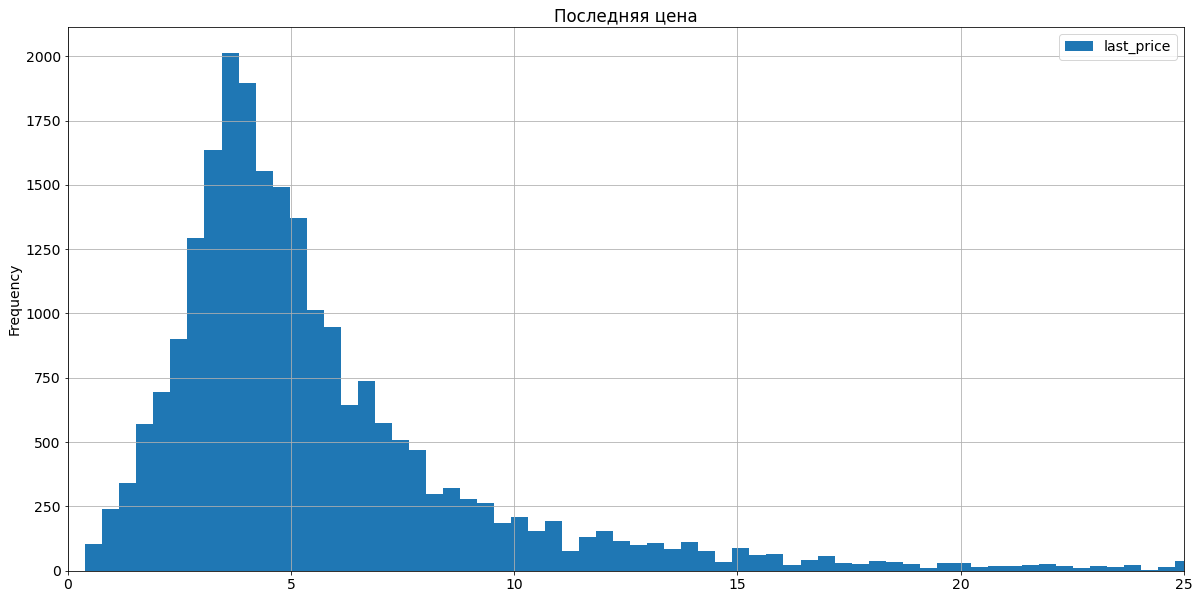

In [57]:
data.plot(kind='hist', title='Последняя цена', y='last_price', bins=2000, grid=True, figsize=(20,10))
plt.xlim([0, 25])
plt.show()

Распределение также напоминает распределение Пуассона. Пик на стоимости недвижимости 4,5 млн.руб. Основная масса укладывается в 3,5 - 6,5 млн.руб.

### Количество комнат

In [58]:
data['rooms'].describe()

count    23177.000000
mean         2.082064
std          1.079989
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

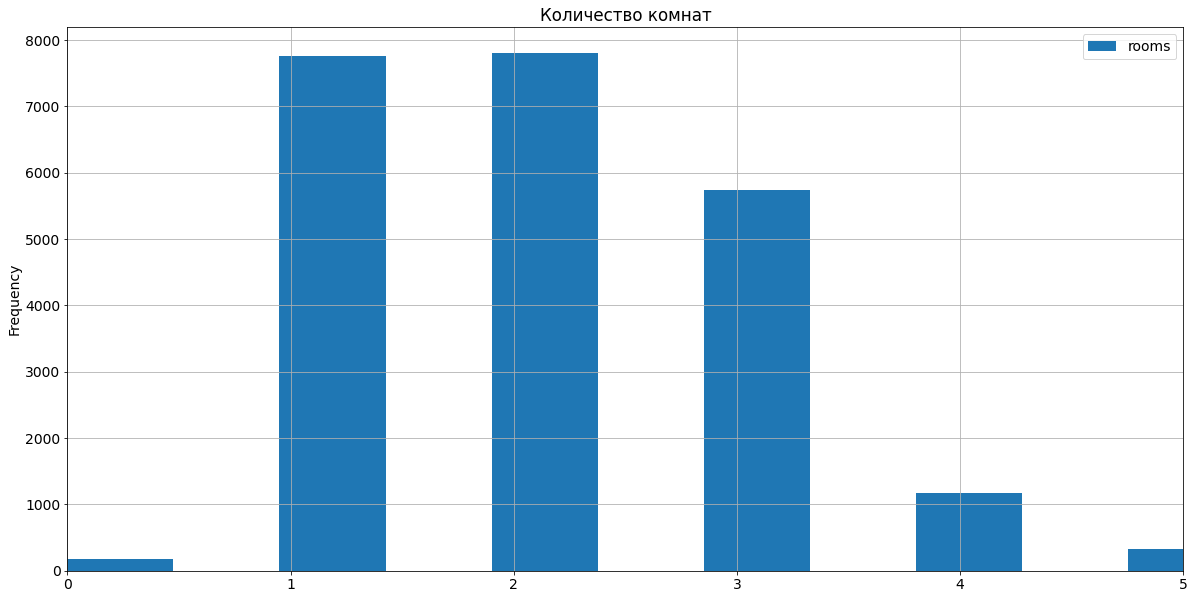

In [59]:
data.plot(kind='hist', title='Количество комнат', y='rooms', bins=40, grid=True, figsize=(20,10))
plt.xlim([0, 5])
plt.show()

Распределение также напоминает распределение Пуассона. Большинство квартир в выборке имеет одну и две комнаты.

### Высота потолков

In [60]:
data['ceiling_height'].describe()

count    23177.000000
mean         2.703122
std          0.222321
min          1.750000
25%          2.550000
50%          2.700000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

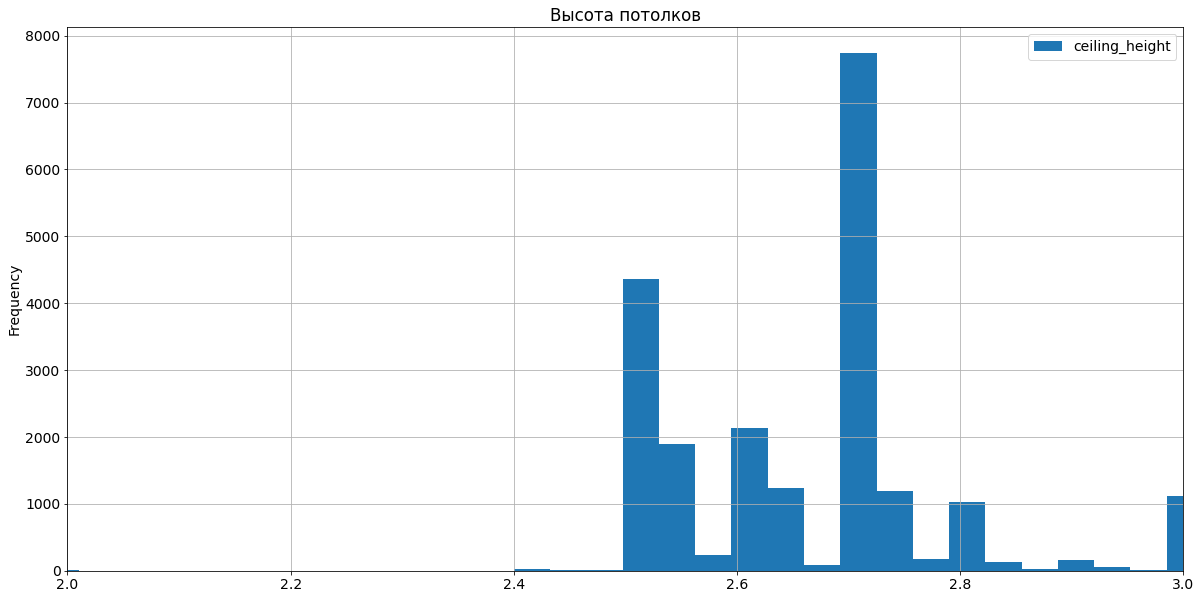

In [61]:
data.plot(kind='hist', title='Высота потолков', y='ceiling_height', bins=100, grid=True, figsize=(20,10))
plt.xlim([2, 3])
plt.show()

Пики на 2,5 и 2,7 м - также связаны с типовой застройкой.

### Этаж квартиры

In [62]:
data['floor'].describe()

count    23177.000000
mean         5.635803
std          4.527506
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

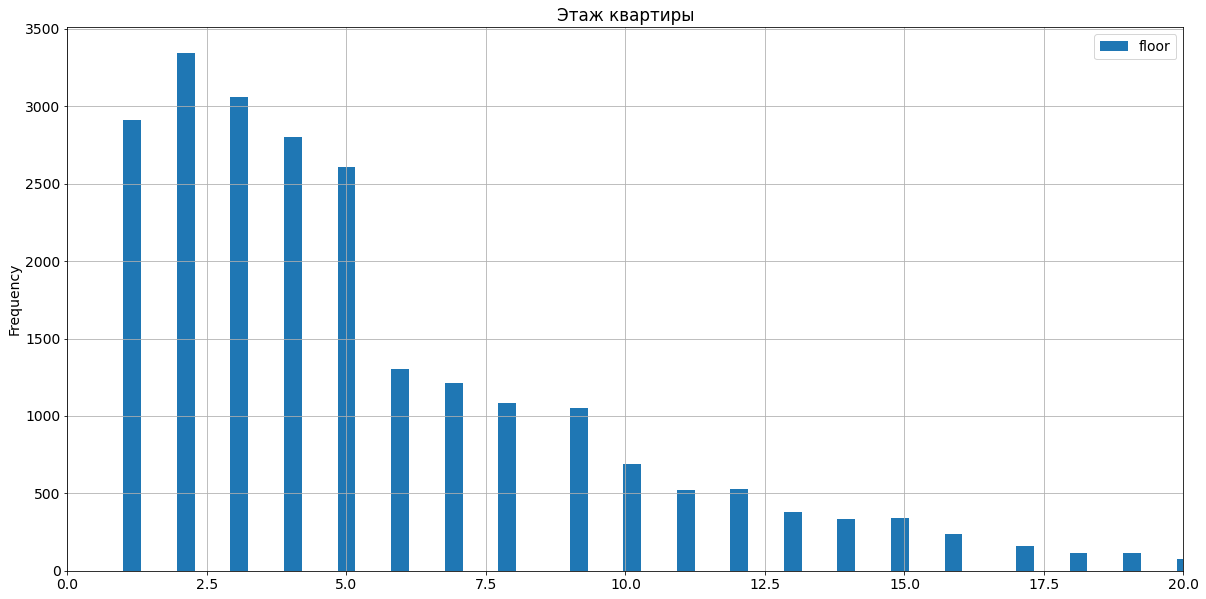

In [63]:
data.plot(kind='hist', title='Этаж квартиры', y='floor', bins=100, grid=True, figsize=(20,10))
plt.xlim([0, 20])
plt.show()

Распределение Пуассона. Большинство квартир располагаются на 2-8 этажах.

### Тип этажа квартиры («первый», «последний», «другой»)

In [64]:
data['type_of_floor'].value_counts()

другой       11807
последний     8461
первый        2909
Name: type_of_floor, dtype: int64

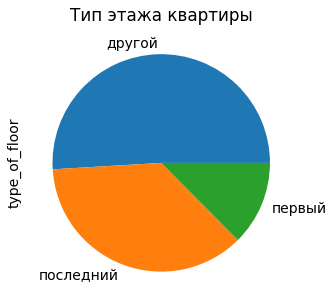

In [65]:
data['type_of_floor'].value_counts().plot(kind='pie', title='Тип этажа квартиры',  figsize=(5,5))
#plt.xlim([0, 20])
plt.show()

Данные могут быть искажены в пользу "последнего" этажа при обработке данных. Но общая тенденция и так хорошо видна.

### Общее количество этажей в доме

In [66]:
data['floors_total'].describe()

count    23177.000000
mean         8.027872
std          4.154195
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         33.000000
Name: floors_total, dtype: float64

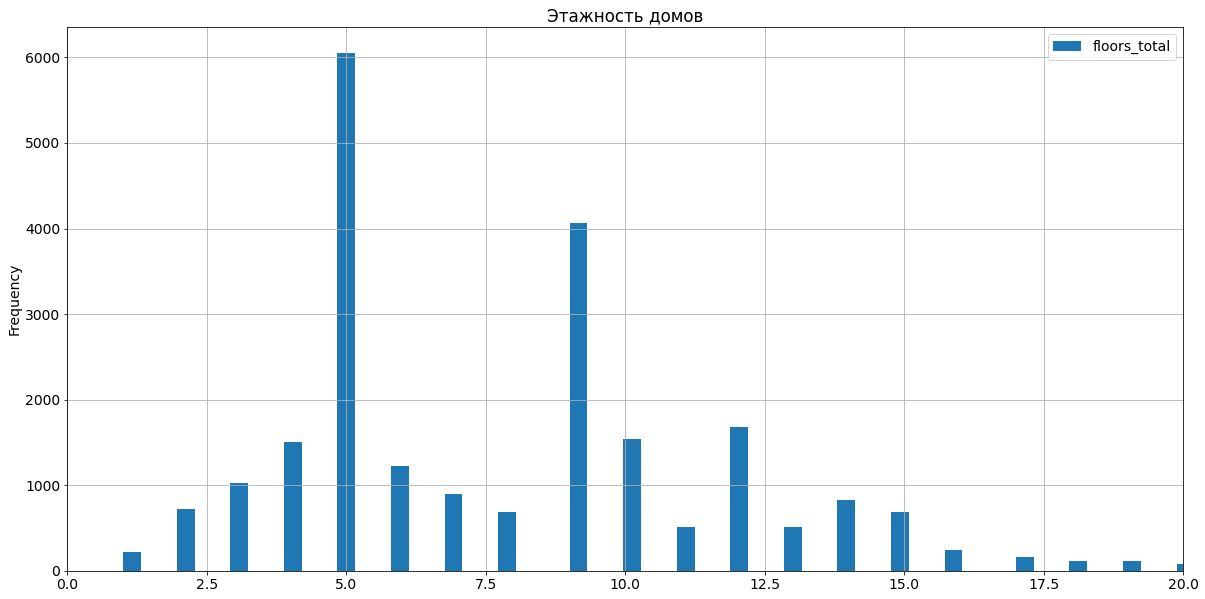

In [67]:
data.plot(kind='hist', title='Этажность домов', y='floors_total', bins=100, grid=True, figsize=(20,10))
plt.xlim([0, 20])
plt.show()

Закономерные пики в зоне типовых 5-ти и 9-этажек.

### Расстояние до центра города в метрах

In [68]:
data['cityCenters_nearest'] = data['cityCenters_nearest'] * 1000
data['cityCenters_nearest'].describe()

count    23177.000000
mean     13900.964620
std       7598.312319
min        181.000000
25%      10871.000000
50%      13056.000000
75%      15204.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

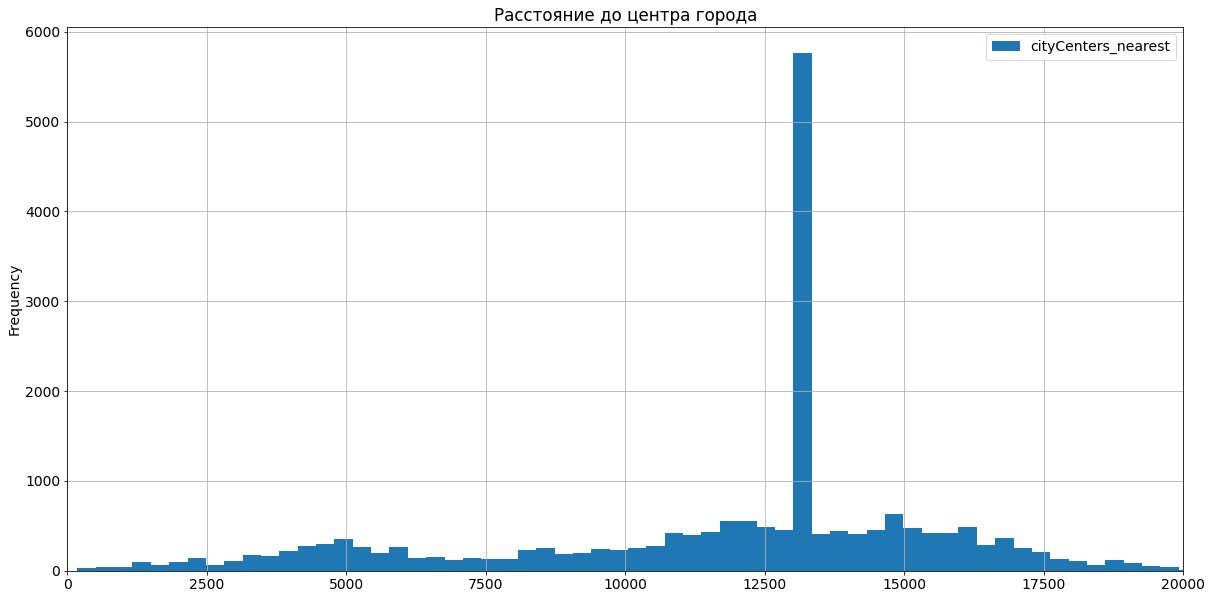

In [69]:
data.plot(kind='hist', title='Расстояние до центра города', y='cityCenters_nearest', bins=200, grid=True, figsize=(20,10))
plt.xlim([0, 20000])
plt.show()

In [70]:
#data_upd = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
#data_upd['cityCenters_nearest'].describe()

In [71]:
#data_upd.plot(kind='hist', title='Расстояние до центра города_необработанное', y='cityCenters_nearest', bins=200, grid=True, figsize=(20,10))
#plt.xlim([0, 20000])
#plt.show()

Высокие значение в зоне 13000, видимо, связаны с проведенной обработкой данных. при загрузке неизмененных данных получаем более плавное распределение с небольшим пиком в районе 5000м и значительным числом случаев в зоне от 10000 до 15000м.

### Расстояние до ближайшего аэропорта

In [72]:
data['airports_nearest'].describe()

count    23177.000000
mean        28.230575
std         11.025190
min          0.000000
25%         21.011000
50%         26.679000
75%         34.330000
max         84.869000
Name: airports_nearest, dtype: float64

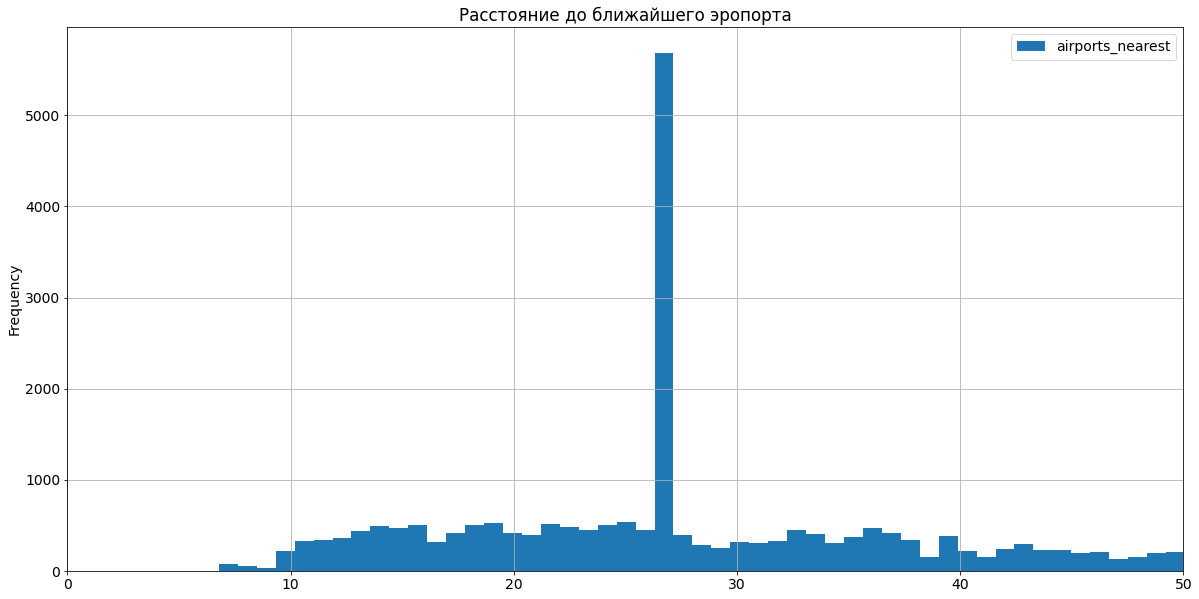

In [73]:
data.plot(kind="hist", title='Расстояние до ближайшего эропорта', y='airports_nearest', bins=100, grid=True, figsize=(20,10))
plt.xlim([0, 50])
plt.show()

Высокие значение в зоне 26км., видимо, связаны с проведенной обработкой данных. при загрузке неизмененных данных получаем более плавное распределение с небольшим пиком в районе 26км и значительным числом случаев в зоне от 20 до 35км.

### Расстояние до ближайшего парка

In [74]:
data['parks_nearest'].describe()

count    8041.000000
mean        0.490905
std         0.342834
min         0.001000
25%         0.287000
50%         0.455000
75%         0.612000
max         3.190000
Name: parks_nearest, dtype: float64

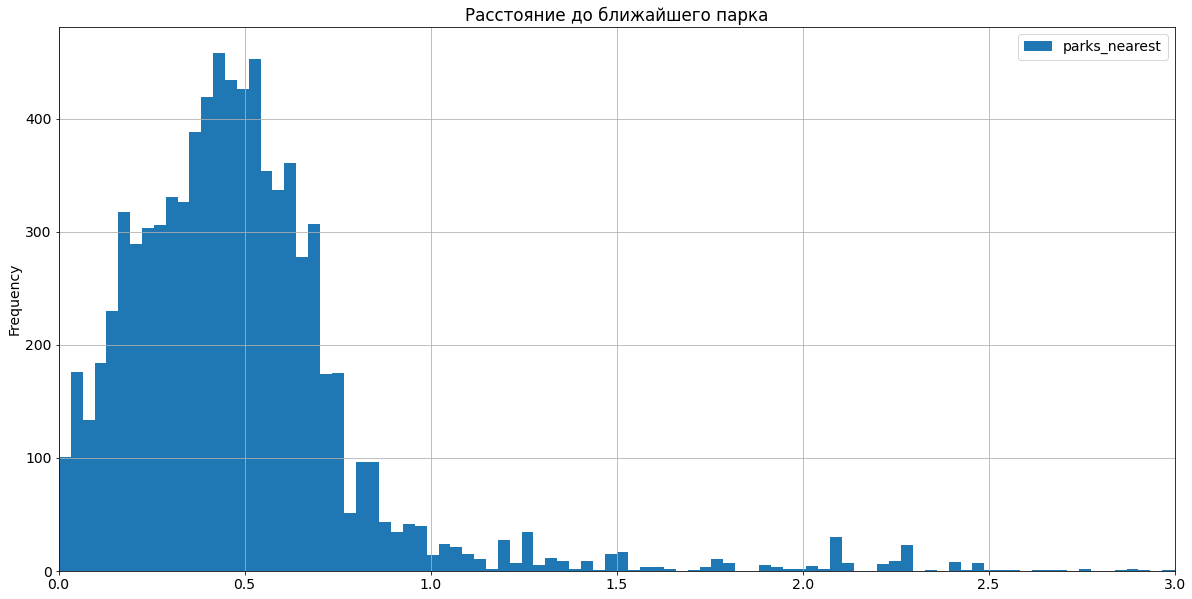

In [75]:
data.plot(kind="hist", title='Расстояние до ближайшего парка', y='parks_nearest', bins=100, grid=True, figsize=(20,10))
plt.xlim([0, 3])
plt.show()

Большинство пользователей указывает парки на расстоянии около 1км. или не указывает парк вовсе.

### День и месяц публикации объявления

In [76]:
data['day_exposition'].describe()

count    23177.000000
mean         2.567804
std          1.788016
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_exposition, dtype: float64

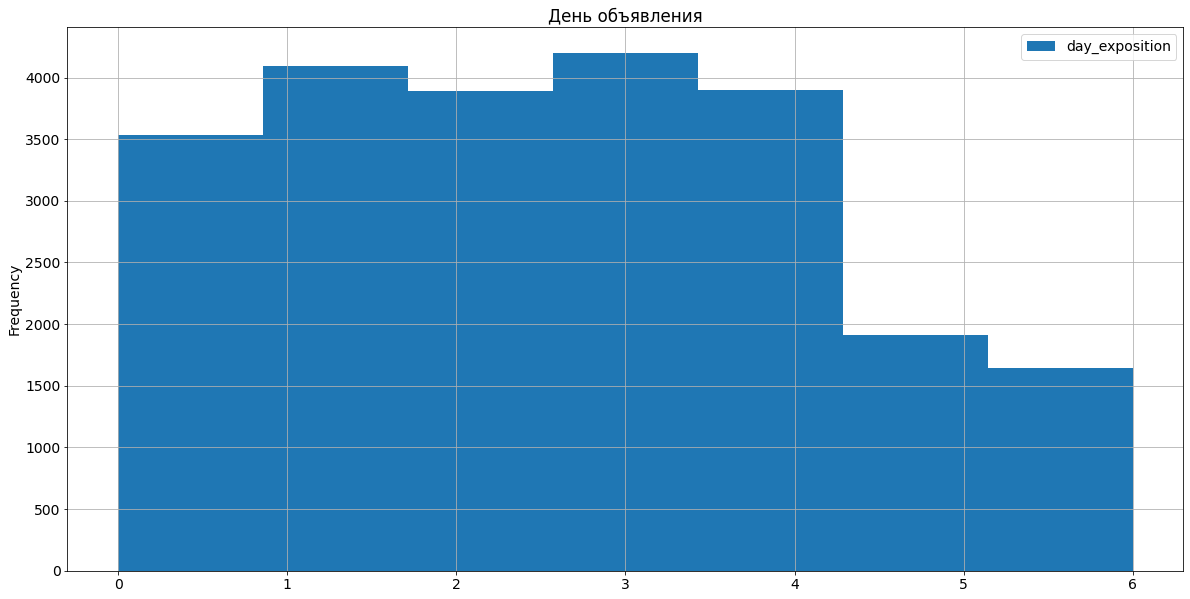

In [77]:
data.plot(kind="hist", title='День объявления', y='day_exposition', bins=7, grid=True, figsize=(20,10))
#plt.xlim([0, 3])
plt.show()

Объявления преимущественно подают в рабочие дни.

In [78]:
data['month_exposition'].describe()

count    23177.000000
mean         6.393623
std          3.490037
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

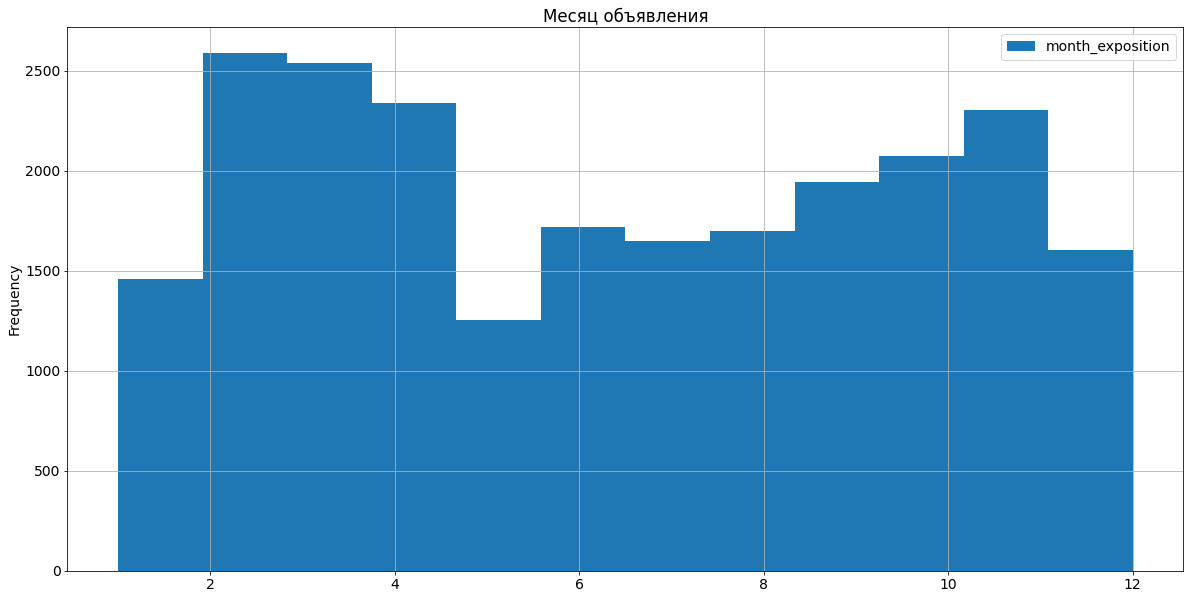

In [79]:
data.plot(kind="hist", title='Месяц объявления', y='month_exposition', bins=12, grid=True, figsize=(20,10))
#plt.xlim([0, 3])
plt.show()

Заметна сезонность в подаче объявлений. Два пика приходятся на февраль-апрель и сентябрь-ноябрь. Максимум объявлений подавали в феврале и ноябре.

## Изучите, как быстро продавались квартиры (столбец days_exposition). 

Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

In [80]:
data['days_exposition'].describe()

count    23177.000000
mean       156.731717
std        214.101988
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

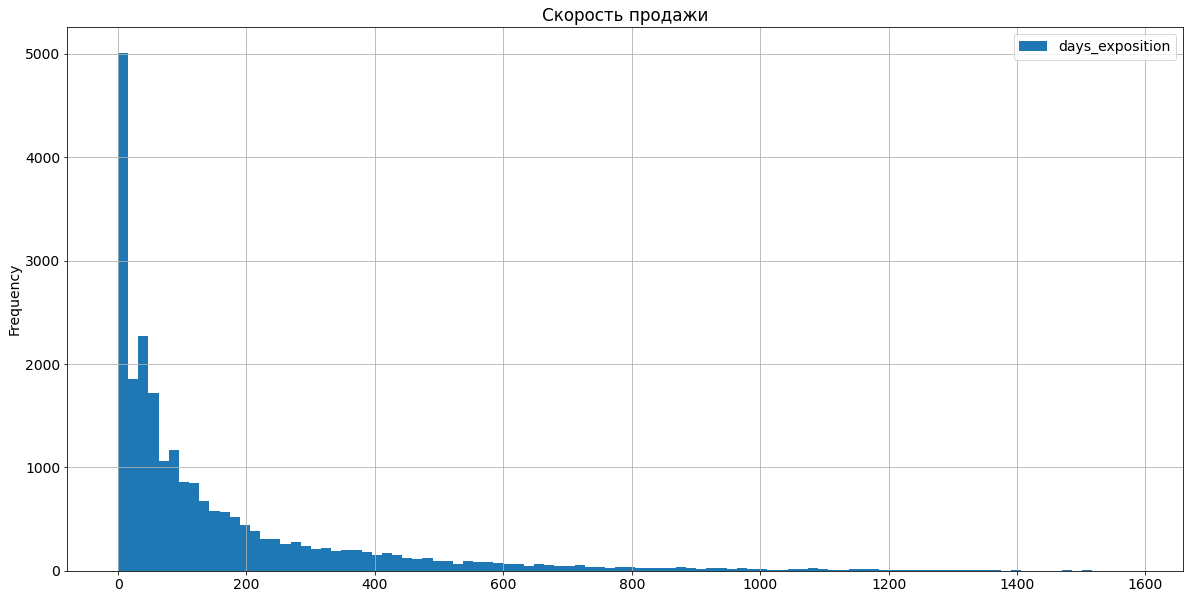

In [81]:
data.plot(kind="hist", title='Скорость продажи', y='days_exposition', bins=100, grid=True, figsize=(20,10))
#plt.xlim([0, 200])
plt.show()

In [82]:
print('Среднее количество дней продажи', data['days_exposition'].mean())
print('Медиана по дням продажи', data['days_exposition'].median())

Среднее количество дней продажи 156.7317167881952
Медиана по дням продажи 74.0


Медиана по дням продажи почти в два раза ниже среднего значения. Возможно, это влияние выбросов длительных продаж на среднее значение.
Величина стандартного отклонения показывает большой разброс данных по дням продажи. По квартилям можно сделать вывод что относительно быстрой продажей можно считать период до 22 дней. Продажи более 200 дней можно считать необычно долгими. Продажи от 75 до 200 дней можно назвать относительно медленным периодом реализации.

Видны пики на значениях 45 и 60 дней. Вероятно это связано тем, что через 1.5 - 2 месяца безуспешных продаж продавец снижает цену и находит клиента

## Какие факторы больше всего влияют на общую (полную) стоимость объекта? 

Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

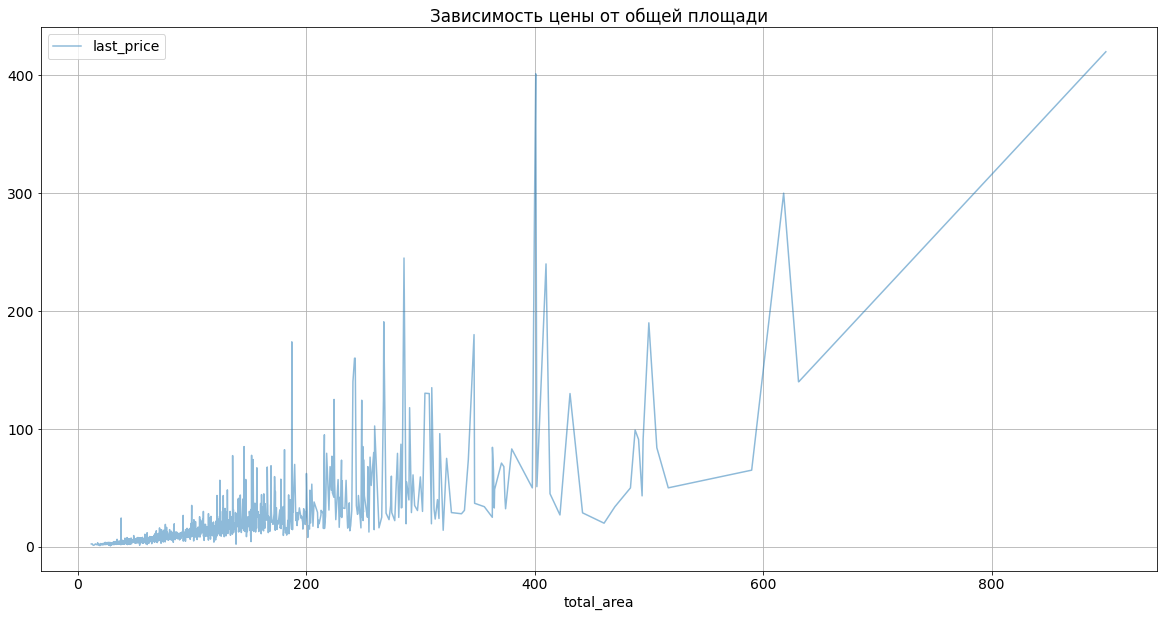

In [83]:
data.pivot_table(index='total_area', values='last_price').plot(style='-', title='Зависимость цены от общей площади', alpha=0.5, grid=True, figsize=(20,10))
plt.show()

In [84]:
print('Коэффициент корреляции цены от общей площади', data['total_area'].corr(data['last_price']), 2)

Коэффициент корреляции цены от общей площади 0.6523365758641426 2


Согласно коэффициенту корреляции - зависимость выявлена. 

На графике зависимости цены от общей площади виден минимальный разброс цен для площади до 120 кв.м, средний разброс цен от 120 до 180 кв.м, и максимальный разброс цен для площадей свыше 180 кв.м. 

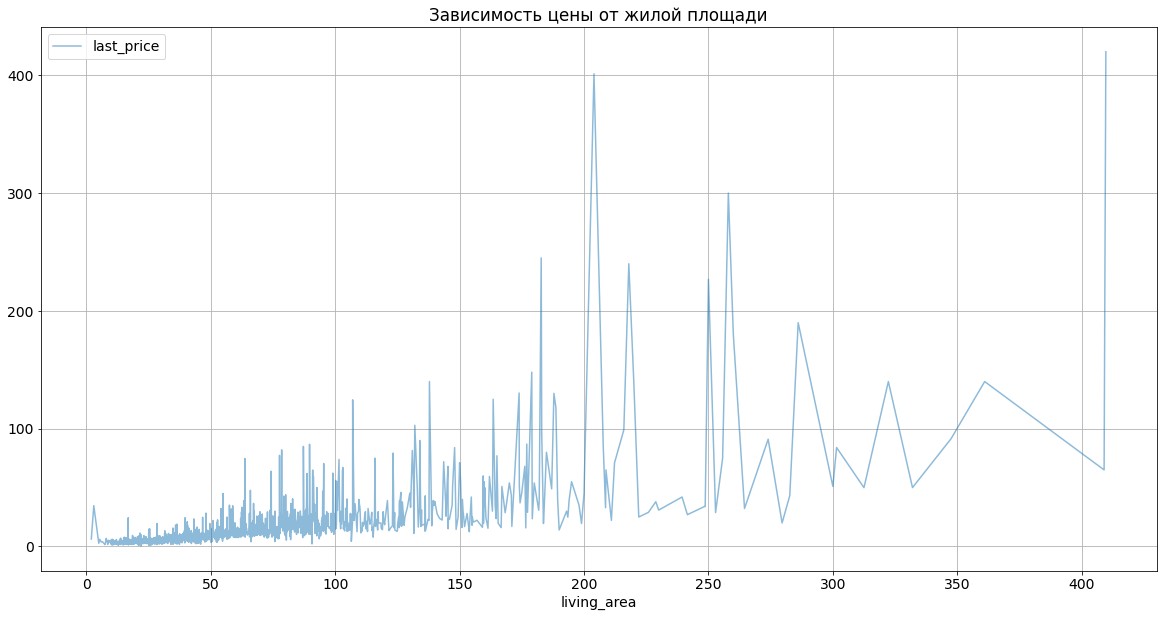

In [85]:
data.pivot_table(index='living_area', values='last_price').plot(style='-', title='Зависимость цены от жилой площади', alpha=0.5, grid=True, figsize=(20,10))
plt.show()

In [86]:
print('Коэффициент корреляции цены от жилой площади', data['living_area'].corr(data['last_price']), 2)

Коэффициент корреляции цены от жилой площади 0.5832407147687604 2


Незначительная корреляция параметров. Более выражена в квартирах до 60кв.м, что ожидаемо.

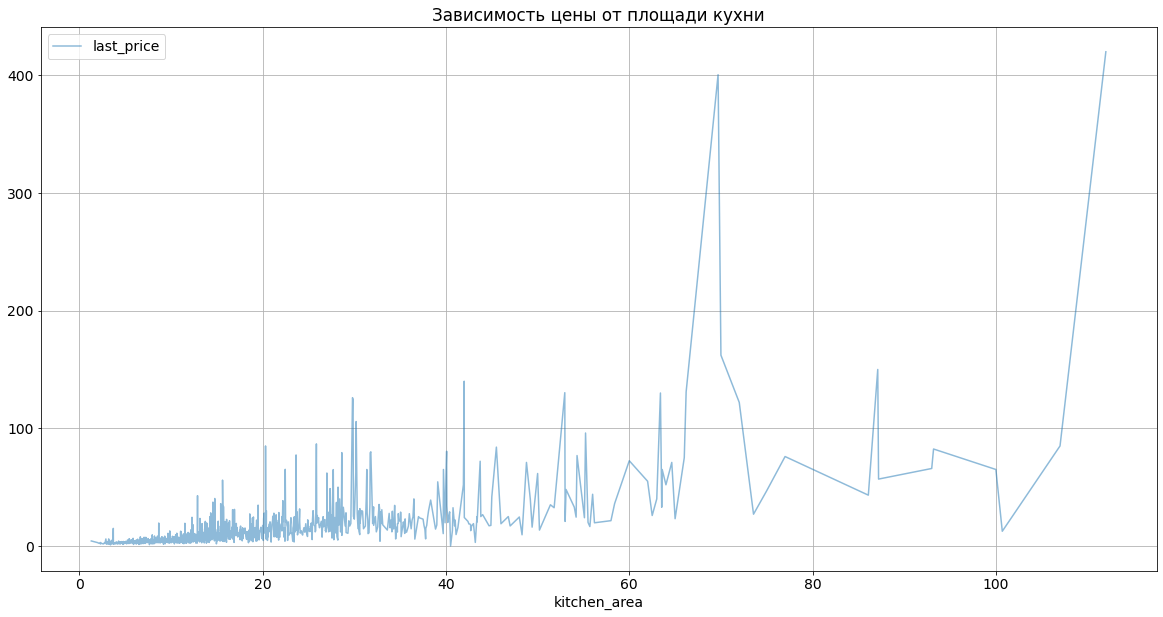

In [87]:
data.pivot_table(index='kitchen_area', values='last_price').plot(style='-', title='Зависимость цены от площади кухни', alpha=0.5, grid=True, figsize=(20,10))
plt.show()

In [88]:
print('Коэффициент корреляции цены от площади кухни', data['kitchen_area'].corr(data['last_price']), 2)

Коэффициент корреляции цены от площади кухни 0.51341131417992 2


Слабая зависимость цены от площади кухни, более выраженная до 10 кв.м.

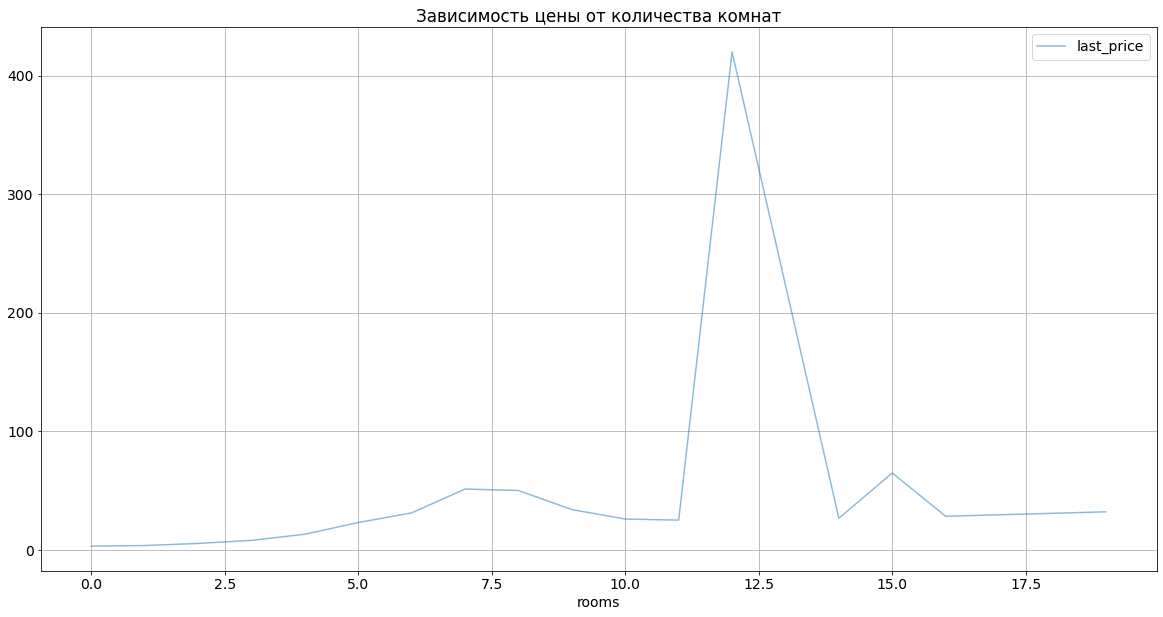

In [89]:
data.pivot_table(index='rooms', values='last_price').plot(style='-', title='Зависимость цены от количества комнат', alpha=0.5, grid=True, figsize=(20,10))
plt.show()

In [90]:
print('Коэффициент корреляции цены от количества комнат', data['rooms'].corr(data['last_price']), 2)

Коэффициент корреляции цены от количества комнат 0.3618616635082731 2


Корреляция не выявлена, что подтверждается графиком

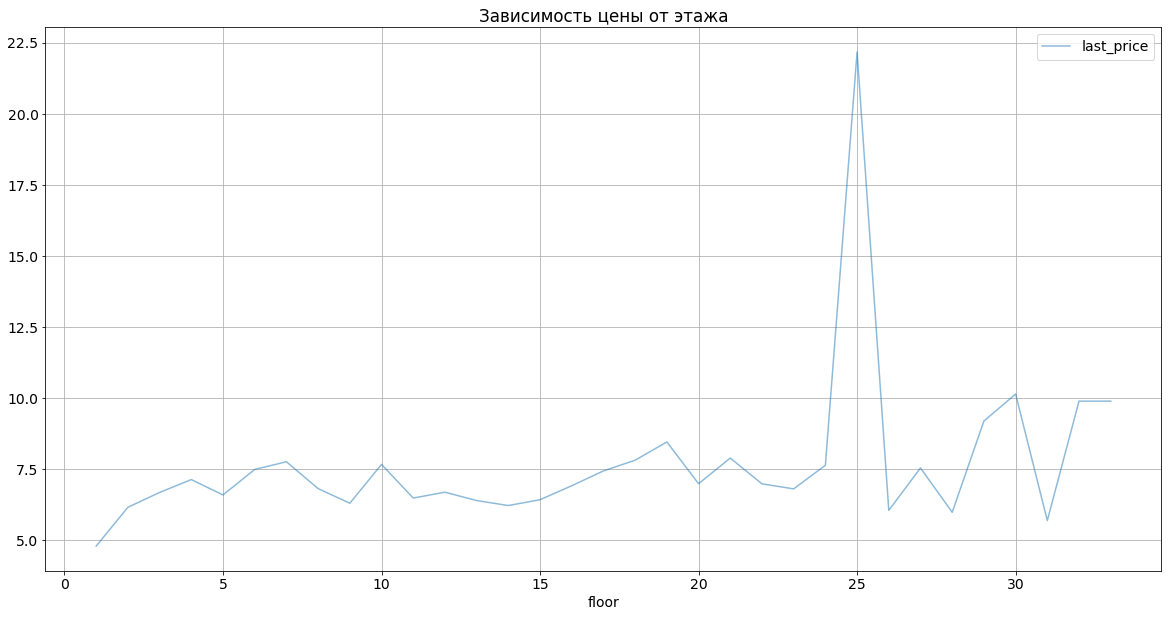

In [91]:
data.pivot_table(index='floor', values='last_price').plot(style='-', title='Зависимость цены от этажа', alpha=0.5, grid=True, figsize=(20,10))
plt.show()

In [92]:
print('Коэффициент корреляции цены от этажа', data['floor'].corr(data['last_price']), 2)

Коэффициент корреляции цены от этажа 0.04244184744944102 2


Корреляция не выявлена, что подтверждается графиком.

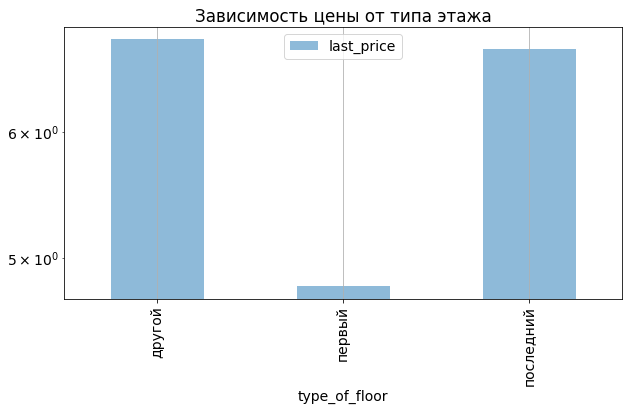

In [93]:
data.pivot_table(index='type_of_floor', values='last_price').plot(kind='bar', title='Зависимость цены от типа этажа', alpha=0.5, grid=True, figsize=(10,5), logy=True)
plt.show()

Квартиры, расположенные на первом этаже значительно дешевле.

## Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

Эти данные можно найти по имени в столбце `locality_name`.

In [94]:
data.pivot_table(index='locality_name', values='last_price', aggfunc=['count', 'mean', 'median'])\
.sort_values(('count', 'last_price'), ascending=False)\
.head(10)\
.sort_values(('mean', 'last_price'), ascending=False)

,count,mean,median
,last_price,last_price,last_price
locality_name,,,
санкт-петербург,15696,8.039577,5.500
пушкин,369,6.469036,5.180
парголово,213,4.455517,4.150
кудрово,387,4.332996,3.890
шушары,387,4.123605,3.990
колпино,336,3.964867,3.600
всеволожск,394,3.793957,3.465
мурино,453,3.699878,3.400


Максимальная цена в Санкт-Петербурге, минимальная в Выборге

## Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [95]:
spb_table = data[data['locality_name']=='санкт-петербург']\
.pivot_table(index='cityCenters_nearest_km', values=['last_price'], aggfunc=['mean'])
spb_table

,mean
,last_price
cityCenters_nearest_km,
0.0,31.449116
1.0,21.274819
2.0,17.788320
3.0,11.135540
4.0,13.322807
5.0,14.346237
6.0,15.133348
7.0,14.543524


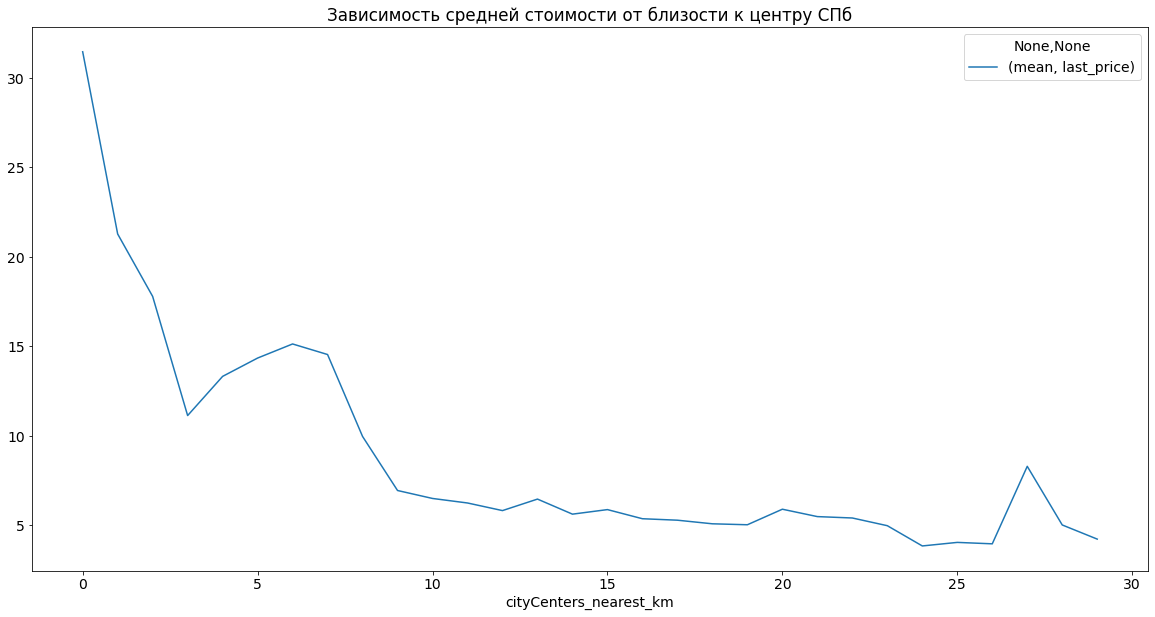

In [96]:
data[data['locality_name']=='санкт-петербург']\
.pivot_table(index='cityCenters_nearest_km', values=['last_price'], aggfunc=['mean'])\
.plot(style='-',title='Зависимость средней стоимости от близости к центру СПб', figsize=(20,10))
plt.show()

Выявлено снижение средней стоимости квартир при удалении от центра. Наиболее дорогая недвижимость от 0 до 2км от центра. Вместе с тем, можно отметить снижение стоимости на расстоянии 3х км, и один из пиков стоимости для 6, 7км. от центра. Также виден небольщой пик на расстояния 27 км. от центра города.

## Общий вывод

В проекте исследованы данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. Целью исследования было выявление особенности и зависимости, которые существуют на рынке недвижимости.

Количество строк данных - 23699 Количество столбцов данных - 22

Выполнена предобработка данных. Проведена оптимизация типов данных. Заполнены пропуски данных там, где это было уместно.

Удалены строки с неизвестным названием населеннго пункта, устранены неявные дубликаты названий населенных пунктов.

Пропущенные значения высоты потолков были заменены медианными по локации.

Были удалены выбросы данных по высоте потолков выше 5 метров и ниже 1,6 метра.

Данные о дате подачи объявления очищены от времени подачи объявления и переведены в более удобный формат.

Данные о днях показа объявления были переведены в более удобный формат и пропуски в них заполнены нулевыми значениями.

Изменен формат полей-пометки о типе недвижимости на логический. 

Изменен тип формата данных об общем числе этажей на более удобный и пропуски в них заполнены на основании данных недвижимости их этого же объявления. Выбросы в данных об этажности во всех населенных пунктах, кроме Санкт-Петербурга заменены на более достоверные данные из этажа расположения недвижимости. Оставшиеся данные, в которых не указан этаж расположения недвижимости удалены.

Пропуски в данных о наличии балконов заменены на нулевые значения.

Пропуски в данных о наличии в радиусе 3км. Парков и водоемов заменены на нулевые значения.

Пропуски в данных о близости к городским центрам и аэропортам заполнены на основании медианы по локациям. (Обработка оказала значительное влияние на выходные данные)

Для большей наглядности данные, представленные в метрах переведены в километра, а данные о стоимости недвижимости представлены в миллионах рублей.

Пропуски в данных о жилой площади п площади кухни заполнены на основании общего среднего значения.

В датафрейм добавлены следующие столбцы, облегчающие последующий анализ: 
- цена одного квадратного метра;
- день публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа недвижимости (первый, последний, другой);
- расстояние в км. До центра города.

Средняя площадь недвижимости около 50кв.м. Пики на отдельных значенияч, видимо вызваны продажей недвижимости типовой застройки. 

В данных о жилой площади имеются три пика в районе 19, 30 и 42кв.м. Также может быть связано с метражом типовой застройки.

Данные о площади кухни таже можгут коррелировать с площадями типовой застройки. Большинство кухонь укладываются в 7 - 12кв.м. 

В данных о стоимости недвижимости имеется пик на стоимости недвижимости 4,5 млн.руб. Основная масса недвижимости укладывается в 3,5 - 6,5 млн.руб. 

Большинство квартир в выборке представлены одно- и двухкомнатными.

Пики на 2,5 и 2,7м., имеющиеся в данных о высоте потолков, также связаны с типовой застройкой 
Большинство недвижимости располагается на 2-8 этажах. Более половины из них располагаются не на первом и не на последнем этажах.

Данные об общей этажности домов имеют закономерные пики в районе пяти- и девятиэтажек, что связано с высоким распространением типовой застройки.

При исследовании расстояния до центра города встречаемся с небольшим пиком в районе 5000м и значительным числом случаев в зоне от 10000 до 15000м.  Большее количество недвижимости продают на окраине города и в пригородах.

При исследовании данных о расстоянии до аэропорта встречаемся с небольшим пиком в районе 26км и значительным числом случаев в зоне от 20 до 35км.

Большинство пользователей указывает парки на расстоянии около 1км. или не указывает парк вовсе.
Объявления преимущественно подают в рабочие дни. Заметна сезонность в подаче объявлений. Два пика приходятся на февраль-апрель и сентябрь-ноябрь. Максимум объявлений подавали в феврале и ноябре. 

В данных о количестве дней показа объявления видны пики на 45 и 60 дней. Видимо, связаны с тем, что в эти сроки продавцы снижают цену на непроданную недвижимость.

Большое влияние на цену продажи оказывает общая площадь недвижимости. Кроме того, выявлено незначительное влияние на стоимость жилой площади и площади кухни. Количество комнат и этажность не влияют на стоимость недвижимости. Недвижимость, расположенная на первом этаже, значительно дешевле.

Максимальная цена квадратного метра выявлена в Санкт-Петербурге. Десятку по величине стоимости недвижимости замыкает Выборг.

Выявлено снижение средней стоимости квартир при удалении от центра. Наиболее дорогая недвижимость от 0 до 2км от центра. Вместе с тем, можно отметить снижение стоимости на расстоянии 3х км, и один из пиков стоимости для 6, 7км. от центра. Также виден небольщой пик на расстояния 27 км. от центра города. 




